Validação cruzada
=================



## Introdução



No notebook 5.1 nós vimos que avaliar a performance de modelos utilizando os dados usados para treinar os modelos nos fornece uma métrica de performance que é *superestimada* (isto é, a performance do modelo aparenta ser melhor do que realmente é).

A solução para buscar uma melhor forma de avaliar a performance dos modelos foi a separação dos dados em um conjunto de treino e um conjunto de teste.

Aqui neste notebook veremos uma estratégia para *seleção de modelos*. Seleção de modelos é diferente de avaliação de modelos. Isto vai ficar claro ao longo deste notebook.



## Carregando os dados necessários



Antes de seguir em frente, precisamos de dados.



In [40]:
from sklearn.model_selection import train_test_split
import seaborn as sns

DATASET_NAME = "penguins"
FEATURES = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
TARGET = ["body_mass_g"]

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455

df = sns.load_dataset(DATASET_NAME)

df = df.reindex(FEATURES + TARGET, axis=1)
df = df.dropna()

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel()

X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel()

X = df.reindex(FEATURES, axis=1).values
y = df.reindex(TARGET, axis=1).values.ravel()

## O acaso vai me proteger&#x2026; se eu não forçar a barra



No código abaixo, nós estamos treinando uma árvore de decisão nos dados dos pinguins que carregamos na seção anterior. Observe o que acontece com a performance do modelo quando variamos a semente aleatória (observe que a performance está sendo medida da maneira correta, isto é, no conjunto de teste).



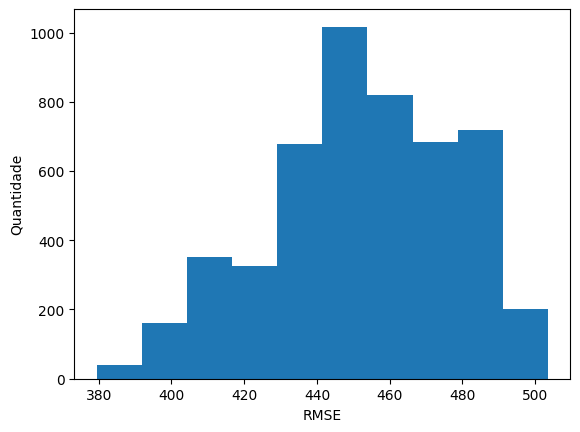

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

N = 5000

resultado = []

for semente in range(N):
    modelo_dt = DecisionTreeRegressor(random_state=semente)

    modelo_dt.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    resultado.append(RMSE)

figura, eixo = plt.subplots()
eixo.hist(resultado)
eixo.set_xlabel("RMSE")
eixo.set_ylabel("Quantidade")
plt.show()

Afinal de contas, qual é a performance deste modelo? Porque variando a semente aleatória a performance varia?

Este experimento que realizamos acima nos mostra que mesmo pequenas variações nas árvores de decisão induzidas pelo modelo resultam em alterações na performance. Estas variações no modelo ocorrem pois alteramos a semente aleatória, releia o notebook 5.2 para relembrar que induzir uma árvore de decisão é um problema NP-difícil e que o `scikit-learn` usa um algoritmo que não necessariamente entrega a melhor resposta.

Por puro acaso, variações no modelo podem prever melhor ou pior os dados de treino, e é por isso que vemos uma distribuição nos valores de performance neste experimento.

Geralmente, não nos preocupamos com o acaso quando treinamos modelos pois esperamos que o efeito do acaso seja pequeno (isto é, assumimos que a nossa avaliação da performance no conjunto de teste é uma estimativa razoável). No entanto, quando &ldquo;forçamos a barra&rdquo; podemos observar situações inusitadas por puro efeito do acaso, como foi o caso do experimento que realizamos acima.

Quando reusamos o mesmo conjunto de teste para diversos modelos diferentes, aumentamos a chance de observar modelos com estimativas de performance muito discrepantes (para mais ou para menos) por pura ação do acaso. Um artigo que discute de forma excelente isso é a referência [1].

O nome técnico deste conceito é &ldquo;vazamento de dados&rdquo; ou *data leakage* em inglês (ver referência [2]). Quando usamos o mesmo conjunto de teste várias vezes, dizemos que a informação dos dados de teste &ldquo;vazaram&rdquo; para o treino (efeito do acaso discutido acima). Outra forma de ocorrer vazamento de dados é quando existem dados duplicados no seu conjunto de dados (isto é, dados com mesmos valores de atributos); desta forma você corre o risco de dados &ldquo;iguais&rdquo; a dados do conjunto de treino cairem no conjunto de teste durante seu split, o que faz com que seu modelo seja treinado com informações que deveriam ser novas (os dados de teste deveriam ser novidade para seu modelo).



## Avaliação de modelos com validação cruzada $k$​-fold



Uma estratégia para reduzir o efeito do acaso para avaliar um modelo induzido por aprendizado de máquina é o processo de *validação cruzada* (cross-validation em inglês).

A validação cruzada mais usada é a chamada de $k$​-fold, representada na imagem abaixo. Nesta estratégia, nós dividimos o conjunto de dados em $k$ subconjuntos diferentes de mesmo tamanho (ou o mais próximo possível disso). Em cada iteração da validação cruzada, um destes subconjuntos é designado como conjunto de teste e os demais como conjunto de treino de forma que todo subconjunto seja teste uma vez.

Nesta estratégia, nós treinamos $k$ modelos e temos $k$ estimativas da performance. A média das $k$ estimativas de performance é o valor que usaremos para avaliar o modelo sendo estudado.

![img](https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg)

Observe que a estratégia de validação cruzada é menos susceptível ao acaso do que a estratégia de split em treino e teste que vimos anteriormente.

A escolha do valor de $k$ é um ponto muito importante. Quanto maior o valor de $k$ maior o custo computacional do processo de validação cruzada. Quanto menor o valor de $k$ pior será sua estimativa da performance. Em geral, um valor de $k=10$ costuma ser muito bom, mas $k=5$ também é considerado bom e menos custoso.

Vamos ver como fazer uma validação cruzada no `scikit-learn`. Note que aqui não fizemos o split de treino e teste pois quem está cuidando disso é a própria função `cross_val_score`. Outro detalhe é que a função `cross_val_score` pode receber o argumento `scoring` que é a medida da performance que temos interesse. Aqui queremos a métrica RMSE e por isso passamos o valor `neg_root_mean_squared_error`. Existem diversos scores possíveis que podemos utilizar para a validação cruzada. Você pode checar as que já estão embutidas no `scikit-learn` na [documentação](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).



In [42]:
from sklearn.model_selection import cross_val_score

NUM_FOLDS = 10

modelo_dt = DecisionTreeRegressor()

metricas = cross_val_score(
    modelo_dt,
    X,
    y,
    cv=NUM_FOLDS,
    scoring="neg_root_mean_squared_error",
)

print("As métricas foram: ", metricas)
print()
print("A média das métricas é de: ", metricas.mean())

As métricas foram:  [-560.08609032 -496.21783811 -495.60569004 -501.65168371 -437.19527203
 -562.23032751 -515.70910633 -456.58982107 -364.25790798 -525.29753474]

A média das métricas é de:  -491.48412718394883


Ué, como assim o RMSE deu negativo? Isso acontece porque o `scikit-learn` definiu que métricas com o nome de *score* devem todas seguir a mesma regra: quanto maior, melhor! No entanto, sabemos que quanto menor o RMSE melhor a performance do meu modelo. Para satisfazer a definição de score do `scikit-learn`, devemos usar o negativo do RMSE como score (por isso tem um `neg` na string que passamos no argumento `scoring`, vem de &ldquo;negativo&rdquo;). Basta você remover o sinal de negativo e terá seu RMSE tradicional como de costume.



In [43]:
print("A média das métricas é de: ", abs(metricas.mean()))

A média das métricas é de:  491.48412718394883


## Otimização de hiperparâmetros



*Avaliar* a performance de modelos é muito importante. No entanto, muitas vezes nós temos interesse em realizar o passo seguinte que é o de *selecionar* modelos. Pode parecer que são processos iguais mas não são!

Seleção de modelos é escolher um bom conjunto de hiperparâmetros para um certo algoritmo de aprendizado de máquina. Este processo também é conhecido como *otimização de hiperparâmetros* ou *hyperparameter tuning* ou simplesmente *hp tuning*.

Este processo envolve os conceitos de split treino-teste com a validação cruzada. Os passos são os seguintes:

1.  Dividir o conjunto de dados em treino e teste;

2.  Realizar validação cruzada considerando apenas o conjunto de treino. Registrar a performance de cada conjunto de hiperparâmetros testados. Escolher o conjunto de hiperparâmetros que resultou na melhor performance;

3.  Treinar um modelo usando os hiperparâmetros encontrados no passo 2 em *todos* os dados de treino;

4.  Avaliar a performance do modelo obtido no passo 3 no conjunto de teste obtido no passo 1.

Uma representação visual pode ser conferida na imagem abaixo. A figura 16 da referência [1] mostra os passos discutidos acima.

![img](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)



## Otimização de hiperparâmetros com `scikit-learn` (busca em grade)



*Problemas de otimização* são problemas onde buscamos maximizar ou minimizar uma função objetivo. O problema de otimização de hiperparâmetros é um tipo de problema de otimização.

Uma estratégia para resolver problemas de otimização é definir todos os valores possíveis dos parâmetros que estamos estudando (neste caso são os hiperparâmetros dos modelos) e estudar os resultados de todas as possíveis combinações entre eles. Esta é a estratégia chamada de *busca em grade*.

Podemos realizar esta busca usando o `scikit-learn`.



In [44]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

NUM_FOLDS = 10

espaco_de_busca = {
    "max_depth": [None, 2, 3, 5, 7, 10],
    "min_samples_split": [1, 2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4]
}

modelo_dt = DecisionTreeRegressor()

buscador = GridSearchCV(
    modelo_dt,
    espaco_de_busca,
    cv=NUM_FOLDS,
    scoring="neg_root_mean_squared_error",
    refit=True,  # reajusta o melhor modelo com todos os dados de treino
    n_jobs=4
)

buscador.fit(X_treino, y_treino)

resultados = pd.DataFrame(buscador.cv_results_)
resultados = resultados.reindex(
["mean_test_score", "std_test_score", "params"], axis=1)
display(resultados)

C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 637, in _validate

,mean_test_score,std_test_score,params
0,NaN,NaN,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
1,-497.812070,71.011870,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
2,-477.790911,71.198823,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
3,-478.651854,64.315350,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
4,NaN,NaN,"{'max_depth': None, 'min_samples_leaf': 2, 'mi..."
...,...,...,...
91,-422.333796,48.798450,"{'max_depth': 10, 'min_samples_leaf': 3, 'min_..."
92,NaN,NaN,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
93,-412.298647,50.635260,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
94,-409.479634,49.755455,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."


Vamos ver o resultado.



In [45]:
print("A melhor métrica (considerando dados de treino) foi de ", abs(buscador.best_score_))
print("O conjunto de hiperparâmetros que resultou nesta métrica foi ", buscador.best_params_)

A melhor métrica (considerando dados de treino) foi de  398.49217574308653
O conjunto de hiperparâmetros que resultou nesta métrica foi  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Agora vamos estimar a performance deste modelo para dados que nunca viu!



In [46]:
y_verdadeiro = y_teste
y_previsao = buscador.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
print(f"O RMSE do modelo escolhido foi de {RMSE} unidades de y.")

O RMSE do modelo escolhido foi de 398.25285598626624 unidades de y.


## Otimização de hiperparâmetros com `scikit-learn` (busca aleatória)



A busca em grade que vimos na seção anterior irá testar todas as combinações possíveis dentro do espaço de busca. Isso pode ser muito custoso se o espaço de busca for muito grande! Para resolver este problema, podemos usar a *busca aleatória* que, como o próprio nome sugere, irá combinar os hiperparâmetros do espaço de busca de forma aleatória em busca de um bom conjunto de hiperparâmetros.

Esta estratégia costuma ser menos custosa, mas em contrapartida não temos garantia de que o melhor conjunto de hiperparâmetros será sorteado durante a busca.



In [50]:
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

NUM_FOLDS = 10
NUM_ITERACOES = 100

espaco_de_busca = {
    "max_depth": [None, 2, 3, 5, 7, 10],
    "min_samples_split": [1, 2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4],
    "max_features": [None, 0.33, "sqrt", "log2"],
}

modelo_dt = DecisionTreeRegressor()

buscador = RandomizedSearchCV(
    modelo_dt,
    espaco_de_busca,
    n_iter=NUM_ITERACOES,
    cv=NUM_FOLDS,
    scoring="neg_root_mean_squared_error",
    refit=True,  # reajusta o melhor modelo com todos os dados de treino
    n_jobs=4,
)

buscador.fit(X_treino, y_treino)

resultados = pd.DataFrame(buscador.cv_results_)
resultados = resultados.reindex(
    ["mean_test_score", "std_test_score", "params"], axis=1 )
resultados

C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
270 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 637, in _validat

,mean_test_score,std_test_score,params
0,-401.648176,75.536094,"{'min_samples_split': 4, 'min_samples_leaf': 3..."
1,-528.730447,109.257151,"{'min_samples_split': 2, 'min_samples_leaf': 1..."
2,-403.264577,52.062017,"{'min_samples_split': 4, 'min_samples_leaf': 1..."
3,NaN,NaN,"{'min_samples_split': 1, 'min_samples_leaf': 3..."
4,NaN,NaN,"{'min_samples_split': 1, 'min_samples_leaf': 1..."
...,...,...,...
95,NaN,NaN,"{'min_samples_split': 1, 'min_samples_leaf': 4..."
96,NaN,NaN,"{'min_samples_split': 1, 'min_samples_leaf': 3..."
97,-395.316083,73.112925,"{'min_samples_split': 2, 'min_samples_leaf': 3..."
98,NaN,NaN,"{'min_samples_split': 1, 'min_samples_leaf': 2..."


Vamos ver o resultado.



In [48]:
print("A melhor métrica (considerando dados de treino) foi de ", abs(buscador.best_score_))
print("O conjunto de hiperparâmetros que resultou nesta métrica foi ", buscador.best_params_)

A melhor métrica (considerando dados de treino) foi de  377.1039500260672
O conjunto de hiperparâmetros que resultou nesta métrica foi  {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5}


Agora vamos estimar a performance deste modelo para dados que nunca viu!



In [49]:
y_verdadeiro = y_teste
y_previsao = buscador.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
print(f"O RMSE do modelo escolhido foi de {RMSE} unidades de y.")

O RMSE do modelo escolhido foi de 576.2012060945017 unidades de y.


## O que fazer quando se tem um grande conjunto de dados?



Quando temos um *grande* conjunto de dados, a validação cruzada pode ser custosa demais de ser realizada. Neste caso, podemos realizar o *método da separação em 3 partes* (3-way holdout method em inglês), também conhecido como *split de treino-teste-validação*. Os passos são os seguintes:

1.  Dividir o conjunto de dados em treino, teste e validação (uma divisão usual é 80-10-10);

2.  Treinar modelos com diferentes hiperparâmetros apenas no conjunto de treino. Escolher o conjunto de hiperparâmetros que apresentar melhor performance na previsão do conjunto de validação.

3.  Treinar um modelo usando os hiperparâmetros encontrados no passo 2 considerando todos os dados de treino e validação;

4.  Avaliar a performance do modelo obtido no passo 3 no conjunto de teste obtido no passo 1.

Para mais informações ver a seção 3.3 da referência [1].



## Referências



1.  RASCHKA, Sebastian. Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning. 2020. Disponível em: [http://arxiv.org/abs/1811.12808](http://arxiv.org/abs/1811.12808). Acesso em: 2 jul. 2023.

2.  KAUFMAN, Shachar; ROSSET, Saharon; PERLICH, Claudia; et al. Leakage in data mining: Formulation, detection, and avoidance. ACM Transactions on Knowledge Discovery from Data, v. 6, n. 4, p. 15:1-15:21, 2012.

3.  Guia sobre validação cruzada do `scikit-learn` [https://scikit-learn.org/stable/modules/cross_validation.html](https://scikit-learn.org/stable/modules/cross_validation.html)

4.  Tutorial sobre validação cruzada [https://dev.to/balapriya/cross-validation-and-hyperparameter-search-in-scikit-learn-a-complete-guide-5ed8](https://dev.to/balapriya/cross-validation-and-hyperparameter-search-in-scikit-learn-a-complete-guide-5ed8)

5.  Documentação da validação cruzada com busca em grade [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

6.  Documentação da validação cruzada com busca aleatória [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

